# Creating a neural network in JAX

[JAX](https://github.com/google/jax) is a new python library that offers autograd and XLA, leading to high-performance machine learning, and numeric research. JAX works just as numpy and using jit (just in time) compilation, you can have high-performance without going to low level languages. One awesome thing is that, just as tensorflow, you can use GPUs and TPUs for acceleration.

# 1) Using vmap, grad and jit

## 1.1) jit

In order to speed up your code, you can use the jit decorator, `@jit` which will cached your operation. Let's compare the speed with and without jit. This example is taken from the [Jax Quickstart Guide](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html)


In [84]:
from jax import random
import jax.numpy as jnp

def selu(x, alpha=1.67, lmbda=1.05):
  return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

key = random.PRNGKey(0)
x = random.normal(key, (1000000,))
%timeit selu(x).block_until_ready()

4.04 ms ± 161 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
from jax import jit
selu_jit = jit(selu)
%timeit selu_jit(x).block_until_ready()

The slowest run took 23.63 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 1.46 ms per loop


We see that with jit, we go 6 ms faster than without jit. Another remark is that we put the `block_until_ready()` method because asynchronous update by default.

## 1.2) grad

Taking the gradient in JAX is pretty easy, you just need to call the `grad` function from the JAX library. Let's begin with a simple example that is calculating the grad of $x^2$. From calculus, we know that:

$$
\frac{\partial x^2}{\partial x} = 2 x
$$

$$
\frac{\partial^2 x^2}{\partial x^2} = 2
$$

$$
\frac{\partial^3 x^2}{\partial x^3} = 0
$$

In [ ]:
from jax import grad
square = lambda x: np.square(x)

grad_square = grad(square)
grad_grad_square = grad(grad(square))
grad_grad_grad_square = grad(grad(grad(square)))
print(f"grad 2² = ", grad_square(2.))
print(f"grad grad 2² = ", grad_grad_square(2.))
print(f"grad grad grad 2² = ", grad_grad_grad_square(2.))

grad 2² =  4.0
grad grad 2² =  2.0
grad grad grad 2² =  0.0


## 1.3) vmap

vmap, or vectorizing map, maps a function along array axes, having better performance mainly when is composed with jit. Let's apply this for matrix-vector products.


In [ ]:
mat = random.normal(key, (150, 100))
batched_x = random.normal(key, (10, 100))

def apply_matrix(v):
  return np.dot(mat, v)

In order to batch naively, we can use a for loop to batch.

In [ ]:
def naively_batched_apply_matrix(v_batched):
  return np.stack([apply_matrix(v) for v in v_batched])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
100 loops, best of 3: 4.63 ms per loop


Now we can use vmap to batch our multiplication

In [ ]:
from jax import vmap

@jit
def vmap_batched_apply_matrix(v_batched):
  return vmap(apply_matrix)(v_batched)

print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
The slowest run took 57.86 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 281 µs per loop


Now we can apply this for creating neural networks.

# 2 ) Using STAX for Convolutional Neural Networks

As a first example, we shall use MNIST (as always) to train a convolutional neural network using stax. It is important to import the original numpy package for shuffling and random generation.

In [85]:
import jax.numpy as jnp
import numpy as np

Let's import MNIST using `tensorflow_datasets` and transform the data into a np.array.

In [2]:
import tensorflow_datasets as tfds
data_dir = '/tmp/tfds'
mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
num_labels = info.features['label'].num_classes
h, w, c = info.features['image'].shape
num_pixels = h * w * c

from IPython.display import clear_output
clear_output()

In [7]:
num_labels

10

In [6]:
info.features['label']

ClassLabel(shape=(), dtype=int64, num_classes=10)

In [3]:
info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/tmp/tfds/mnist/incomplete.SB66UU_3.0.1/',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [4]:
info.features['image'].shape

(28, 28, 1)

In [5]:
num_pixels

784

In [11]:
train_data['label']

array([4, 1, 0, ..., 6, 1, 5])

In [19]:
train_data['label'][:, None]

array([[4],
       [1],
       [0],
       ...,
       [6],
       [1],
       [5]])

In [14]:
np.arange(num_labels)

Array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [33]:
arr = [[5], [8]]
output = []
sub = []
for n in arr:
  for i in range(1, 11):
    if i == n[0]:
      sub.append(1)
    else:
      sub.append(0)
  output.append(sub)
  sub = []

print(output)




[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]


In [31]:
print(np.array([4]== [4]))

True


Let's split the training and test dataset and one hot encode the labels of our data.

In [16]:
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k """
    return np.array(x[:, None] == np.arange(k), dtype)

# Full train set
train_images, train_labels = train_data['image'], train_data['label']
train_images = np.array(np.moveaxis(train_images, -1, 1), dtype=np.float32)

train_labels = one_hot(train_labels, num_labels)

# Full test set
test_images, test_labels = test_data['image'], test_data['label']
test_images = np.array(np.moveaxis(test_images, -1, 1), dtype=np.float32)
test_labels = one_hot(test_labels, num_labels)

In [86]:
arr=jnp.arange(1,10).reshape((3,3))
arr

Array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]], dtype=int32)

In [99]:
key = random.PRNGKey(0)
arr2 = random.normal(key, (10,))
arr3 = random.randint(key, (3, 3), minval=1, maxval=9)

In [109]:
arr4 = random.normal(key, (9,) ).reshape((3,3))

In [110]:
arr4

Array([[-0.3721109 ,  0.26423115, -0.18252768],
       [-0.7368197 ,  0.44973662, -0.1521442 ],
       [-0.67135346, -0.5908641 ,  0.73168886]], dtype=float32)

In [111]:
jnp.moveaxis(arr4, -1, 1)

Array([[-0.3721109 ,  0.26423115, -0.18252768],
       [-0.7368197 ,  0.44973662, -0.1521442 ],
       [-0.67135346, -0.5908641 ,  0.73168886]], dtype=float32)

In [100]:
arr3

Array([[3, 2, 4],
       [7, 2, 6],
       [7, 4, 5]], dtype=int32)

In [98]:
arr2

Array([-0.3721109 ,  0.26423115, -0.18252768, -0.7368197 , -0.44030377,
       -0.1521442 , -0.67135346, -0.5908641 ,  0.73168886,  0.5673026 ],      dtype=float32)

In [94]:
jnp.moveaxis(arr, -1, 1)

Array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]], dtype=int32)

In [105]:
jnp.moveaxis(arr3, -1, 1)

Array([[3, 2, 4],
       [7, 2, 6],
       [7, 4, 5]], dtype=int32)

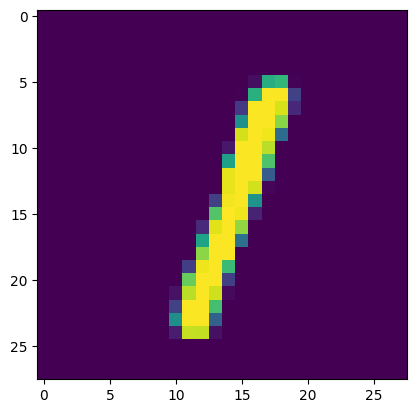

In [52]:
plt.imshow(train_data['image'][1])

In [38]:
import cv2
import matplotlib.pyplot as plt

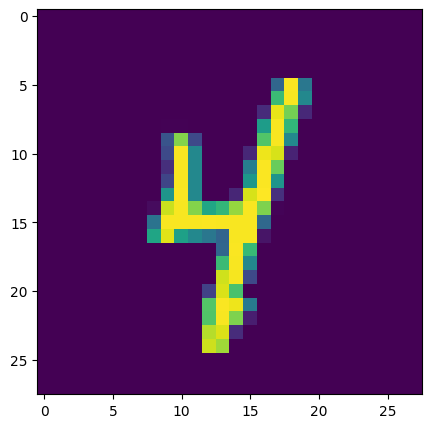

In [42]:
plt.figure(figsize = (5,5))
plt.imshow(train_images[0][0])
plt.show()

In [43]:
# code to print second image in dataframe
print(train_images[1][0])

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   9. 159. 169.   2.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   1. 162. 254. 254.  49.   0.   0.   0.   0.   0.  

In [18]:
train_labels[:2]

Array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Now we need to construct a data_stream which will generate our batch data, this data stream will shuffle the training dataset. First let's define the batch size and how many batches should be used for going through all the data.

In [ ]:
batch_size = 128
num_train = train_images.shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

In [ ]:
def data_stream():
  """Creates a data stream with a predifined batch size.
  """
  rng = onp.random.RandomState(0)
  while True:
    perm = rng.permutation(num_train)
    for i in range(num_batches):
      batch_idx = perm[i * batch_size: (i + 1)*batch_size]
      yield train_images[batch_idx], train_labels[batch_idx]

batches = data_stream()

Now let's construct our network, we will contruct a simple convolutional neural network with 4 convoclutional blocks with batchnorm and relu and a dense softmax as output of the neural network.

First you define your neural network using `stax.serial` and get the init_fun and conv_net, the former is the initialization function of the network and the latter is your neural network which we will use on the update function.

After defining our network, we initialize it using the init function and we get our network parameters which we will optimize.

In [ ]:
from jax.experimental import stax
from jax import random
from jax.experimental.stax import (BatchNorm, Conv, Dense, Flatten,
                                   Relu, LogSoftmax)

init_fun, conv_net = stax.serial(Conv(32, (5, 5), (2, 2), padding="SAME"),
                                 BatchNorm(), Relu,
                                 Conv(32, (5, 5), (2, 2), padding="SAME"),
                                 BatchNorm(), Relu,
                                 Conv(10, (3, 3), (2, 2), padding="SAME"),
                                 BatchNorm(), Relu,
                                 Conv(10, (3, 3), (2, 2), padding="SAME"), Relu,
                                 Flatten,
                                 Dense(num_labels),
                                 LogSoftmax)


key = random.PRNGKey(0)
_, params = init_fun(key, (-1,) + train_images.shape[1:]) # -1 for varying batch size

Now let's define the accuracy and the loss function.

In [ ]:
def accuracy(params, batch):
  """ Calculates the accuracy in a batch.

  Args:
    params : Neural network parameters.
    batch : Batch consisting of images and labels.

  Outputs:
    (float) : Mean value of the accuracy.
  """

  # Unpack the input and targets
  inputs, targets = batch

  # Get the label of the one-hot encoded target
  target_class = np.argmax(targets, axis=1)

  # Predict the class of the batch of images using
  # the conv_net defined before
  predicted_class = np.argmax(conv_net(params, inputs), axis=1)

  return np.mean(predicted_class == target_class)

In [ ]:
def loss(params, batch):
  """ Cross entropy loss.
  Args:
    params : Neural network parameters.
    batch : Batch consisting of images and labels.

  Outputs:
    (float) : Sum of the cross entropy loss over the batch.
  """
  # Unpack the input and targets
  images, targets = batch
  # precdict the class using the neural network
  preds = conv_net(params, images)

  return -np.sum(preds * targets)

Let's define which optimizer we shall use for training our neural network. Here we shall select the adam optimizer and initialize the optimizer with our neural network parameters.

In [ ]:
from jax.experimental import optimizers

step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

In order to create our update function for the network, we shall use the `jit` decorator to make things faster.

Inside the update function we take the value and gradient of the loss function given for the given parameters and the dataset and update our parameters using the optimizer.

In [ ]:
from jax import jit, value_and_grad

@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """

    # Take the gradient and evaluate the loss function
    value, grads = value_and_grad(loss)(params, (x, y))

    # Update the network using the gradient taken
    opt_state = opt_update(0, grads, opt_state)

    return get_params(opt_state), opt_state, value

Now we shall create a training loop for the neural network, we run the loop for a number of epochs and run on all data using the data_stream that we defined before.

Then we record the loss and accuracy for each epoch.

In [ ]:
from tqdm.notebook import tqdm
train_acc, test_acc = [], []
train_loss, val_loss = [], []


num_epochs = 10

for epoch in tqdm(range(num_epochs)):
  for _ in range(num_batches):
    x, y = next(batches)
    params, opt_state, _loss = update(params, x, y, opt_state)


  # Update parameters of the Network
  params = get_params(opt_state)

  train_loss.append(np.mean(loss(params, (train_images, train_labels)))/len(train_images))
  val_loss.append(loss(params, (test_images, test_labels))/len(test_images))

  train_acc_epoch = accuracy(params, (train_images, train_labels))
  test_acc_epoch = accuracy(params, (test_images, test_labels))

  train_acc.append(train_acc_epoch)
  test_acc.append(test_acc_epoch)

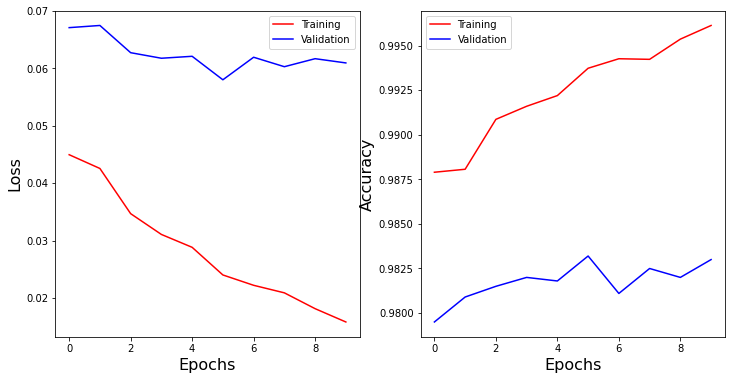

In [ ]:
epochs = range(num_epochs)

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.plot(epochs, train_loss, 'r', label='Training')
ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.legend()

ax2.plot(epochs, train_acc, 'r', label='Training')
ax2.plot(epochs, test_acc, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()
plt.show()

Now we have successfully created and trained a neural network using JAX!

------------------------

# References

- [Robert Lang Blog](https://roberttlange.github.io/posts/2020/03/blog-post-10/)

- [JAX Quickstart](https://jax.readthedocs.io/en/stable/notebooks/quickstart.html)

- [Training a Simple Neural Network, with tensorflow/datasets Data Loading](https://github.com/google/jax/blob/master/docs/notebooks/neural_network_with_tfds_data.ipynb)